# Pair Trading Strategy

## Import data

In [1]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
import datetime

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
import itertools

In [2]:
data = pd.read_csv('/Users/Jagonii/Desktop/Y-Intercept_data.csv')
data = data.pivot(index='date', columns='ticker', values='last')
data

ticker,1332 JT,1333 JT,1334 JT,1605 JT,1721 JT,1801 JT,1802 JT,1803 JT,1808 JT,1812 JT,...,9503 JT,9531 JT,9532 JT,9602 JT,9613 JT,9681 JT,9735 JT,9766 JT,9983 JT,9984 JT
date,,,,,,,,,,,,,,,,,,,,,
2013-01-04,169.0987,NaN,147.8887,970.6780,950.5521,1232.0186,413.2189,278.1162,NaN,478.8201,...,847.8471,1727.7597,1332.1473,1367.1194,487.5256,567.3170,3719.2396,1721.7623,20584.8363,1482.3931
2013-01-07,166.3266,NaN,144.9890,960.1615,924.2187,1236.1949,411.5426,278.1162,NaN,480.4769,...,804.2336,1744.7820,1327.9713,1364.4123,475.2036,594.1617,3732.0499,1695.8510,21150.4557,1453.9312
2013-01-08,166.3266,NaN,144.9890,955.9548,938.6596,1215.3132,407.3517,277.2709,NaN,473.8496,...,795.5109,1761.8042,1340.4993,1377.0457,470.5604,585.2135,3736.3199,1627.9455,21243.1802,1472.9058
2013-01-09,165.4026,NaN,144.9890,944.3866,945.4553,1240.3712,417.4098,278.9616,NaN,482.1337,...,780.6823,1766.0598,1336.3233,1440.2130,479.3109,631.7442,3757.6703,1612.7561,21159.7281,1442.0720
2013-01-10,167.2507,NaN,144.9890,942.2833,943.7564,1252.9002,435.0114,284.8789,NaN,490.4178,...,810.3395,1757.5487,1340.4993,1516.0136,481.9896,619.2167,3791.8310,1568.9749,20918.6445,1442.0720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15,560.0000,2718.0,NaN,826.0000,3330.0000,4240.0000,1014.0000,921.0000,1509.0,1585.0000,...,1206.0000,2375.5000,2122.0000,4275.0000,1767.0000,NaN,9726.0000,7090.0000,95390.0000,10370.0000
2021-03-16,559.0000,2713.0,NaN,828.0000,3320.0000,4255.0000,1027.0000,928.0000,1540.0,1594.0000,...,1208.5000,2407.5000,2137.0000,4410.0000,1748.0000,NaN,9694.0000,7200.0000,95190.0000,10620.0000
2021-03-17,561.0000,2732.0,NaN,808.0000,3400.0000,4220.0000,1007.0000,909.0000,1553.0,1558.0000,...,1193.0000,2450.0000,2150.0000,4335.0000,1764.0000,NaN,9680.0000,7200.0000,96000.0000,10400.0000


## Cointegration

- Correlation describes a short-term relationship between the returns.
- Cointegration describes a long-term relationship between the prices.
- As cointegrated assets should theoretically have a narrow spread in long-term equilibrium, a hedge fund strategy is to bet on the spread by long–short or relative-value arbitrage. If the spread widens, then the strategy is to short the high asset and buy the low one. As the spread narrows to some equilibrium value, unwinding the position results in a profit.

In [3]:
def cointegrated_pairs(data):
    n =  (len(data.columns) -1)
    stocks = data.iloc[:,1:].columns.values #pulls all stock names 
    #data = data.to_numpy()
    pvalue_matrix = np.zeros((n,n),dtype = float)
    pairs = np.empty((n*n,2),dtype=object)
    m = 0
    #loop through all possilbe combintions of stocks ie 3!=6
    for i in range(n-1):
        for j in range(i+1, n):
            temp = pd.concat([data.iloc[:,i], data.iloc[:,j]], axis = 1)
            temp = temp.dropna()
            if len(temp) == 0:
                result = 0
                pvalue_matrix[i,j] = float('nan')
            else:
                result = ts.coint(temp.iloc[:,0], temp.iloc[:,1])
                pvalue_matrix[i,j] = result[1]
                if (result[1] < 0.05) & (i!=j):
                    pairs[m,0] = stocks[i]
                    pairs[m,1] = stocks[j] 
                m = m +1
    return pvalue_matrix,  pairs

This step costs 4hours to finish

In [4]:
#pvalues, pairs = cointegrated_pairs(data)
#pd.DataFrame(pvalues).to_csv("pvalues.csv")
#pd.DataFrame(pairs).to_csv("pairs.csv")

In [5]:
pairs = pd.read_csv('pairs.csv')
pairs = pairs.iloc[:,1:]
pairs.dropna(inplace=True)
pairs.reset_index(inplace=True, drop=True)
pairs

,0,1
0,1333 JT,2269 JT
1,1333 JT,4004 JT
2,1333 JT,4519 JT
3,1333 JT,6367 JT
4,1333 JT,8803 JT
...,...,...
2022,9613 JT,9681 JT
2023,9613 JT,9766 JT
2024,9735 JT,9766 JT
2025,9735 JT,9983 JT


## Firstly I select the first pair to demo

In [6]:
S1_name, S2_name = pairs.iloc[0][0], pairs.iloc[0][1]
set = pd.DataFrame({S1_name: data[S1_name], S2_name: data[S2_name]})
set.dropna(inplace=True)
set['ratio'] = set['1333 JT'] / set['2269 JT']
set

,1333 JT,2269 JT,ratio
date,,,
2014-04-02,1590.8200,2850.8293,0.558020
2014-04-03,1587.1354,2823.4175,0.562133
2014-04-04,1580.6874,2805.1429,0.563496
2014-04-07,1553.9741,2777.7311,0.559440
2014-04-08,1553.0530,2777.7311,0.559108
...,...,...,...
2021-03-15,2718.0000,7170.0000,0.379079
2021-03-16,2713.0000,7140.0000,0.379972
2021-03-17,2732.0000,7090.0000,0.385331


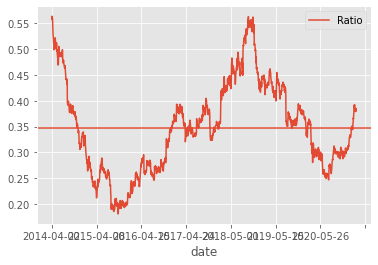

In [7]:
set['ratio'].plot()
plt.axhline(set['ratio'].mean())
plt.legend(['Ratio'])
plt.show()

In [8]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

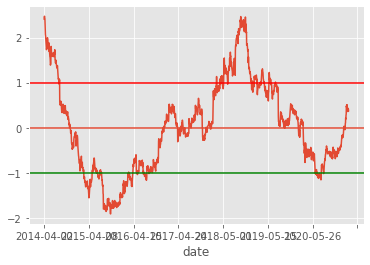

In [9]:
zscore(set['ratio']).plot()
plt.axhline(zscore(set['ratio']).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

## Split Data

In [10]:
train = set['ratio'].iloc[:len(set)*7//10]
test = set['ratio'].iloc[len(set)*7//10:]

## Feature Engineering

- 60 day Moving Average of Ratio: Measure of rolling mean
- 5 day Moving Average of Ratio: Measure of current value of mean
- 60 day Standard Deviation
- z score: (5d MA — 60d MA) /60d SD

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

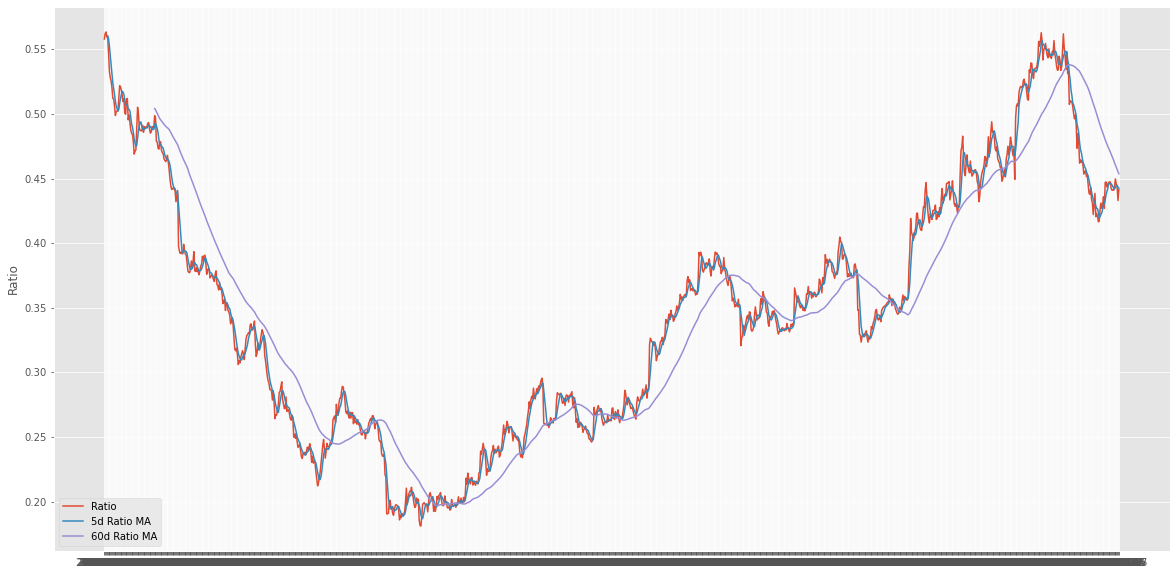

In [11]:
ratios_ma5 = train.rolling(window=5, center=False).mean()
ratios_ma60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_ma5 - ratios_ma60)/std_60

plt.figure(figsize=(20,10))
plt.plot(train.index, train.values)
plt.plot(ratios_ma5.index, ratios_ma5.values)
plt.plot(ratios_ma60.index, ratios_ma60.values)
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show();

### We can find that there are mean-reverting at around +/- 1 or +/- 2

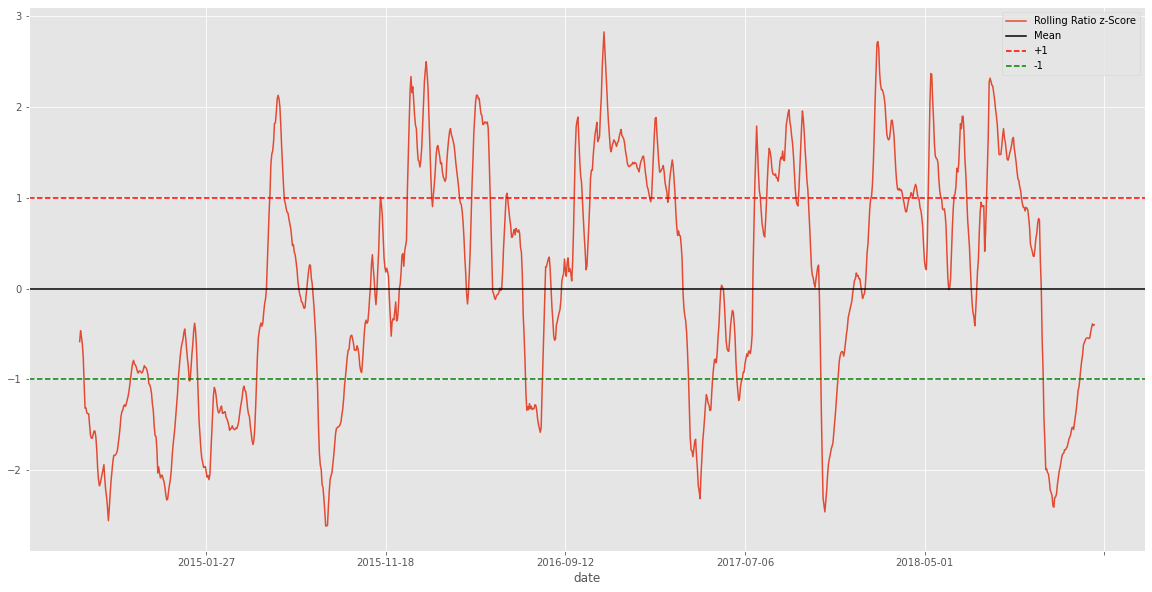

In [12]:
plt.figure(figsize=(20,10))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

## Trading Strategy

Whenever the z-score feature gets too high, or too low, it tends to revert back. Let’s use +1/-1 as our thresholds for too high and too low, then we can use the following model to generate a trading signal:

How to determine the criteria of above or below certain level is the key thing for this strategy. It can be used from very simple (Z-score) to extremely complex (CNN, ResNet, etc). Because of the time limit, here I just use the simple way to decide long or short position.

- When the z-score is below -1.0 (or other criteria) because we expect z score to go back up to 0 --> Long the ratio (1)
- When the z-score is above 1.0 (or other criteria) because we expect z score to go back down to 0 --> Short the ratio (-1)

### Visualization

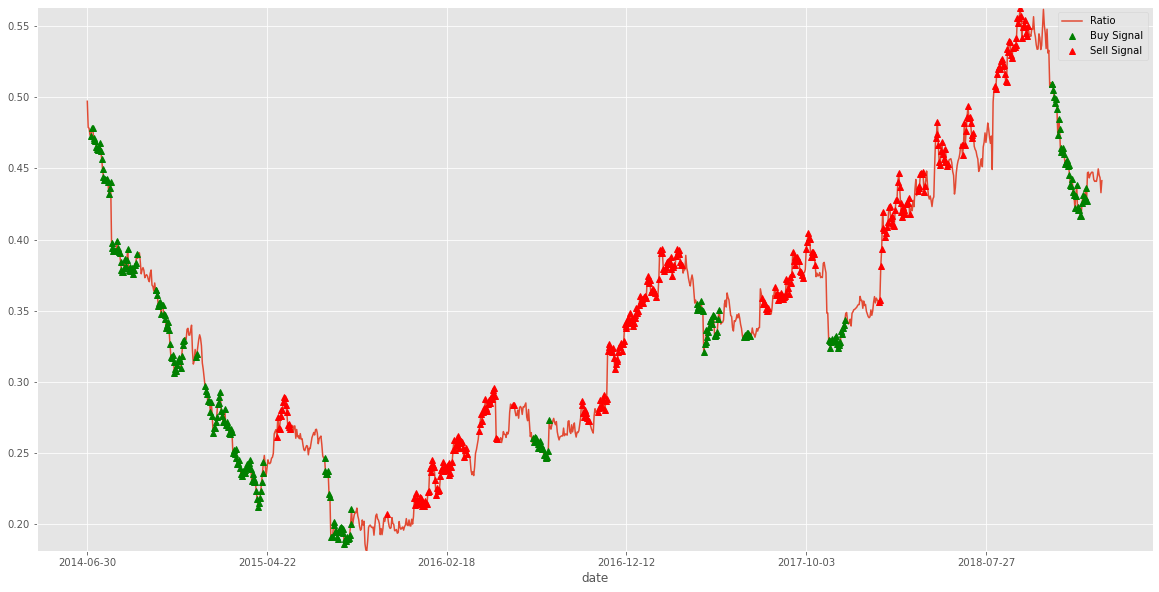

In [13]:
criteria = [-1, 1]
plt.figure(figsize=(20,10))
train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>criteria[0]] = 0
sell[zscore_60_5<criteria[1]] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,set['ratio'].min(),set['ratio'].max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

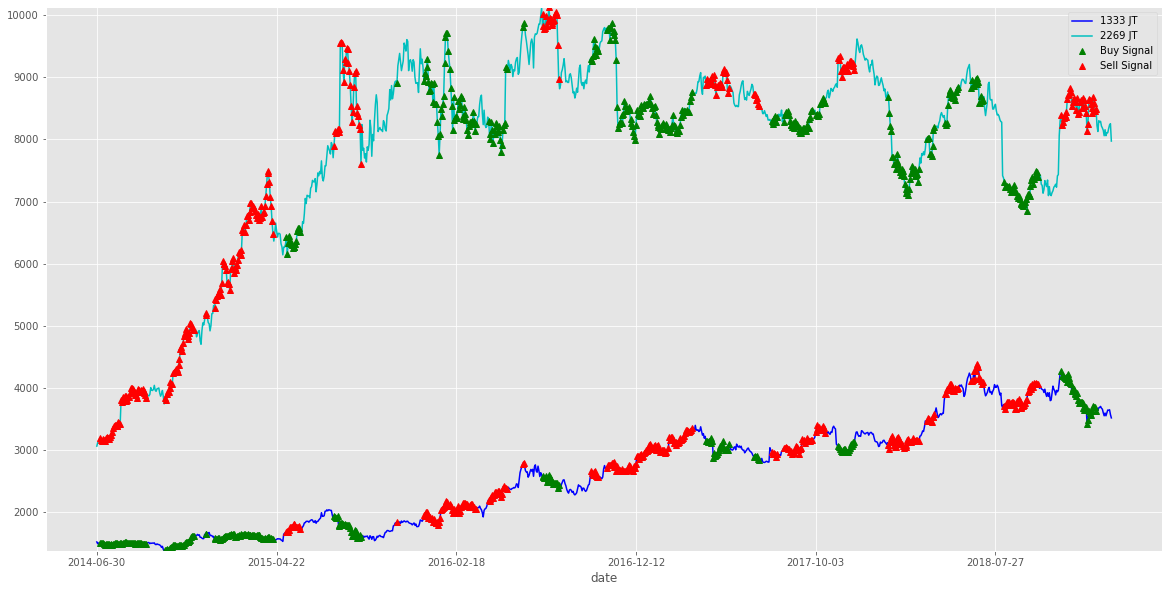

In [14]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(20,10))
S1 = set[S1_name].iloc[:len(set)*7//10]
S2 = set[S2_name].iloc[:len(set)*7//10]
S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]
buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.legend([S1_name,S2_name, 'Buy Signal', 'Sell Signal'])
plt.show()

## Function for easily apply to different pairs and criteria and backtesting

With this code, it's convenient for us to change the dataset, compare all pairs, and set different criteria by just adjusting the input

In [15]:
def PnL(data, pair, window1, window2, criteria):
    
    S1_name, S2_name = pair[0], pair[1]
    set = pd.DataFrame({S1_name: data[S1_name], S2_name: data[S2_name]})
    set.dropna(inplace=True)
    train = set.iloc[:len(set)*7//10]
    test = set.iloc[len(set)*7//10:]

    S1_train = train[S1_name]
    S2_train = train[S2_name]
    S1_test = test[S1_name]
    S2_test = test[S2_name]

    pnl_train = trade(S1_train, S2_train, window1, window2, criteria)
    pnl_test = trade(S1_test, S2_test, window1, window2, criteria)

    return pnl_train, pnl_test

def trade(S1, S2, window1, window2, criteria):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > criteria[0]:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1, countS2))
        # Buy long if the z-score is < 1
        elif zscore[i] < criteria[1]:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money, ratios[i], countS1, countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money, ratios[i], countS1, countS2))

    return money

### Case 1: +/- 1 zscore

In [16]:
PnL_train, PnL_test = PnL(data, [pairs.iloc[0][0], pairs.iloc[0][1]], 5, 60, [1, -1])
print('PnL for training data:', PnL_train)
print('PnL for testing data:', PnL_test)

PnL for training data: -39633.41194725949
PnL for testing data: 9351.76342813061


### Case 2: +/- 1.5 zscore

In [17]:
PnL_train, PnL_test = PnL(data, [pairs.iloc[0][0], pairs.iloc[0][1]], 5, 60, [1.5, -1.5])
print('PnL for training data:', PnL_train)
print('PnL for testing data:', PnL_test)

PnL for training data: -25154.376157886847
PnL for testing data: 6696.106087415682


## ALL PAIRS

We can put all pairs into my model and find the best performer, but because my kernel is not powerful enough, I cannot finish the cell. On top of that, even I use zscore method, we can optimize it by grid search. But because of the time I didn't put it into practice.

In [30]:
pair = []
pnl_training = []
pnl_testing = []
for i in range(len(pairs)):
    pair.append([pairs.iloc[i][0], pairs.iloc[i][1]])
    PnL_train, PnL_test = PnL(data, [pairs.iloc[i][0], pairs.iloc[i][1]], 5, 60, [1, -1])
    pnl_training.append(PnL_train)
    pnl_testing.append(pnl_testing)

res = pd.DataFrame({'Pair': pair, 'PnL for training data': pnl_training, 'PnL for testing data': pnl_testing})
res

: 

: 